<a href="https://colab.research.google.com/github/jsilv21/bulldozer-price-prediction-project/blob/master/bulldozer_price_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚜 Predicting the Sale Price of Bulldozers using Machine Learning

In this notebook, we're going to go through an example machine learning project with the goal of predicting the sale price of bulldozers.

## 1. Problem defition

> How well can we predict the future sale price of a bulldozer, given its characteristics and previous examples of how much similar bulldozers have been sold for?

## 2. Data

The data is downloaded from the Kaggle Bluebook for Bulldozers competition: https://www.kaggle.com/c/bluebook-for-bulldozers/data

There are 3 main datasets:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## 3. Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more on the evaluation of this project check: https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

**Note:** The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model which minimises RMSLE.

## 4. Features

Kaggle provides a data dictionary detailing all of the features of the dataset. You can view this data dictionary on Google Sheets: https://docs.google.com/spreadsheets/d/18ly-bLR8sbDJLITkWG7ozKm8l3RyieQ2Fpgix-beSYI/edit?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn


## EDA 

In [ ]:
# Import training and validation sets
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/bluebook-for-bulldozers/TrainAndValid.csv", low_memory=False)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [ ]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

In [ ]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

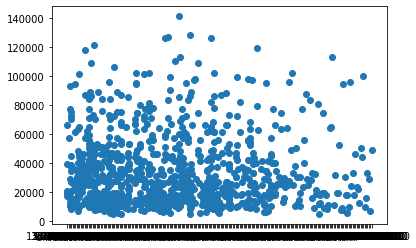

In [ ]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000]);

In [ ]:
df.saledate.describe()

count             412698
unique              4013
top       2/16/2009 0:00
freq                1932
Name: saledate, dtype: object

In [ ]:
df.saledate.dtype

dtype('O')

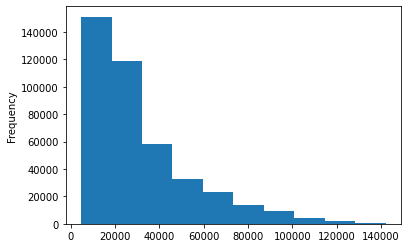

In [ ]:
df.SalePrice.plot.hist();

### Parsing dates

When we work with time series data, we want to enrich the time & date component as much as possible.

We can do that by telling pandas which of our columns has dates in it using the `parse_dates` parameter.


In [ ]:
# Import data again but this time parse dates
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/bluebook-for-bulldozers/TrainAndValid.csv",
                 low_memory=False,
                 parse_dates=["saledate"])

In [ ]:
df.saledate.dtype

dtype('<M8[ns]')

In [ ]:
#converted to YYYY-MM--DD
df.saledate[:1000]

0     2006-11-16
1     2004-03-26
2     2004-02-26
3     2011-05-19
4     2009-07-23
         ...    
995   2009-07-16
996   2007-06-14
997   2005-09-22
998   2005-07-28
999   2011-06-16
Name: saledate, Length: 1000, dtype: datetime64[ns]

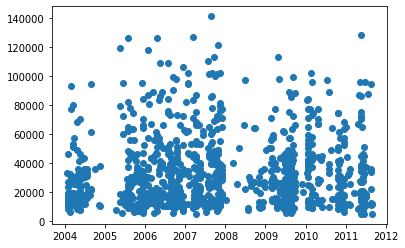

In [ ]:
#plotting sales by date & price now that data is formatted
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000]);

In [ ]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,521D,521,D,NaN,NaN,NaN,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,950FII,950,F,II,NaN,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,23.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,226,226,NaN,NaN,NaN,NaN,Skid Steer Loader - 1351.0 to 1601.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,OROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,PC120-6E,PC120,NaN,-6E,NaN,Small,"Hydraulic Excavator, Track - 12.0 to 14.0 Metr...",Texas,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,S175,S175,NaN,NaN,NaN,NaN,Skid Steer Loader - 1601.0 to 1751.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,EROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#transposing dataframe to see all columns
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000,57000,10000,38500,11000
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68,4640,2838,3486,722
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [ ]:
df.saledate.head(20)

0    2006-11-16
1    2004-03-26
2    2004-02-26
3    2011-05-19
4    2009-07-23
5    2008-12-18
6    2004-08-26
7    2005-11-17
8    2009-08-27
9    2007-08-09
10   2008-08-21
11   2006-08-24
12   2005-10-20
13   2006-01-26
14   2006-01-03
15   2006-11-16
16   2007-06-14
17   2010-01-28
18   2006-03-09
19   2005-11-17
Name: saledate, dtype: datetime64[ns]

### Sort DataFrame by saledate

When working with time series data, it's a good idea to sort it by date.

In [ ]:
# Sort DataFrame in date order
df.sort_values(by=["saledate"], inplace=True, ascending=True)
df.saledate.head(20)

205615   1989-01-17
233186   1989-01-31
142491   1989-01-31
115536   1989-01-31
92301    1989-01-31
115892   1989-01-31
134080   1989-01-31
92294    1989-01-31
31494    1989-01-31
140922   1989-01-31
66337    1989-01-31
92531    1989-01-31
82122    1989-01-31
92256    1989-01-31
145670   1989-01-31
92780    1989-01-31
238373   1989-01-31
127132   1989-01-31
115102   1989-01-31
32317    1989-01-31
Name: saledate, dtype: datetime64[ns]

### Make a copy of the original DataFrame

We make a copy of the original dataframe so when we manipulate the copy, we've still got our original data.

In [ ]:
# Make a copy of the original DataFrame to perform edits on
df_tmp = df.copy()

## Feature Engineering 

### Add datetime parameters for `saledate` column

In [ ]:
#https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DatetimeIndex.html

df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleDayOfWeek"] = df_tmp.saledate.dt.dayofweek
df_tmp["saleDayOfYear"] = df_tmp.saledate.dt.dayofyear

In [ ]:
df_tmp.head().T

,205615,233186,142491,115536,92301
SalesID,1646770,1728883,1508502,1452578,1403418
SalePrice,9500,30000,21000,33000,24000
MachineID,1126363,1523610,1153157,1544443,1390168
ModelID,8434,9105,4138,3854,7110
datasource,132,132,132,132,132
auctioneerID,18,99,99,99,99
YearMade,1974,1986,1972,1974,1986
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [ ]:
# Now we've enriched our DataFrame with date time features, we can remove 'saledate'
df_tmp.drop("saledate", axis=1, inplace=True)

In [ ]:
# Check the values of different columns
df_tmp.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

In [ ]:
len(df_tmp)

412698

## 5. Modelling 

In [ ]:
#using RandomForestRegressor

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs = -1, random_state=42)

model.fit(df_tmp.drop("SalePrice", axis=1), df_tmp["SalePrice"])

ValueError: ignored

In [ ]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-nul

In [ ]:
#usage band is object - have to fix it 
df_tmp["UsageBand"].dtype

dtype('O')

In [ ]:
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

### More model-driven EDA

### Convert string to categories

One way we can turn all of our data into numbers is by converting them into pandas **categories**

We can check the different datatypes compatible with pandas here: https://pandas.pydata.org/pandas-docs/stable/reference/general_utility_functions.html#data-types-related-functionality

In [ ]:
df_tmp.head().T

,205615,233186,142491,115536,92301
SalesID,1646770,1728883,1508502,1452578,1403418
SalePrice,9500,30000,21000,33000,24000
MachineID,1126363,1523610,1153157,1544443,1390168
ModelID,8434,9105,4138,3854,7110
datasource,132,132,132,132,132
auctioneerID,18,99,99,99,99
YearMade,1974,1986,1972,1974,1986
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,WA150,D7F,966C,416


In [ ]:
pd.api.types.is_string_dtype(df_tmp["UsageBand"])

True

In [ ]:
#Find columns with strings.

for label, content in df_tmp.items(): # .items gives key, values for columns & data.
    if pd.api.types.is_string_dtype(content):
        print(label)
        

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [ ]:
# If you're wondering what df.items() does, here's an example
random_dict = {"key1": "hello",
               "key2": "world!"}

for key, value in random_dict.items():
    print(f"this is a key: {key}",
          f"this is a value: {value}")

this is a key: key1 this is a value: hello
this is a key: key2 this is a value: world!


In [ ]:
# This will turn all of the string value into category values
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()

In [ ]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

In [ ]:
df_tmp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [ ]:
#now all categories have a numerical code for Regression
#see codes for each line
df_tmp.state.cat.codes

205615    43
233186     8
142491     8
115536     8
92301      8
          ..
409901     4
405777     4
411889     4
411890     4
409203     4
Length: 412698, dtype: int8

#### Still need to fix missing data...


In [ ]:
# Check missing data percentages
df_tmp.isnull().sum()/len(df_tmp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

### Save preprocessed data - Can start here when resuming kernel

In [ ]:
# Export current tmp dataframe
df_tmp.to_csv("/content/drive/My Drive/Colab Notebooks/bluebook-for-bulldozers/train_tmp.csv",
              index=False)

In [4]:
#re-mounting google drive (if starting from here)
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

# Import preprocessed data
df_tmp = pd.read_csv("/content/drive/My Drive/Colab Notebooks/bluebook-for-bulldozers/train_tmp.csv",
                     low_memory=False)
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1728883,1508502,1452578,1403418
SalePrice,9500,30000,21000,33000,24000
MachineID,1126363,1523610,1153157,1544443,1390168
ModelID,8434,9105,4138,3854,7110
datasource,132,132,132,132,132
auctioneerID,18,99,99,99,99
YearMade,1974,1986,1972,1974,1986
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,WA150,D7F,966C,416


## Fill missing values 

### Fill numerical missing values first

In [6]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayOfWeek
saleDayOfYear


In [7]:
df_tmp.ModelID

0          8434
1          9105
2          4138
3          3854
4          7110
          ...  
412693     4605
412694     6868
412695    17231
412696    17231
412697     4701
Name: ModelID, Length: 412698, dtype: int64

In [8]:
# Check for which numeric columns have null values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [9]:
# Fill numeric rows with the median
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells us if the data was missing or not
            df_tmp[label+"_is_missing"] = pd.isnull(content)
            # Fill missing numeric values with median
            df_tmp[label] = content.fillna(content.median())

Using median instead of mean because median is less likely to be skewed by outliers.
E.g. 1000 rows of "100", and one row of "100000", median is much better fill value than the mean.

In [10]:
# Check if there's any null numeric values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [ ]:
# Check to see how many examples were missing
df_tmp.auctioneerID_is_missing.value_counts()

False    392562
True      20136
Name: auctioneerID_is_missing, dtype: int64

### Filling and turning categorical variables into numbers

In [11]:
# Check for columns which aren't numeric
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [12]:
# Turn categorical variables into numbers and fill missing
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        #add binary column to indicate whether sample had missing value
        df_tmp[label+"_is_missing"] = pd.isnull(content)
        #turn categories into numbers and add + 1
        df_tmp[label] = pd.Categorical(content).codes + 1 #adding +1 because missing value comes to  -1 normally.

In [13]:
pd.Categorical(df_tmp["state"]).codes + 1 #adding +1 because missing value comes to  -1 normally.

array([44,  9,  9, ...,  5,  5,  5], dtype=int8)

In [14]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int16(4), int64(10), int8(40)
memory usage: 77.9 MB


In [15]:
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1728883,1508502,1452578,1403418
SalePrice,9500,30000,21000,33000,24000
MachineID,1126363,1523610,1153157,1544443,1390168
ModelID,8434,9105,4138,3854,7110
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,True
Blade_Type_is_missing,False,True,False,True,True
Travel_Controls_is_missing,False,True,False,True,True
Differential_Type_is_missing,True,True,True,False,True


In [16]:
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

Now that all of data is numeric as well as our dataframe has no missing values, we should be able to build a machine learning model.

In [17]:
%%time
#instantiate model 
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1, random_state = 42)

#fit the model against X & Y. X is df with SalePrice dropped (saleprice is our Y)
model.fit(df_tmp.drop("SalePrice", axis=1), df_tmp["SalePrice"])

CPU times: user 20min 12s, sys: 3.21 s, total: 20min 15s
Wall time: 10min 16s


In [18]:
# Score the model 
model.score(df_tmp.drop("SalePrice", axis=1), df_tmp["SalePrice"])

0.9875966080326709

This metric isn't reliable - **we're scoring on the same data we trained on.**

### Splitting data into train/validation sets

In [19]:
df_tmp.saleYear

0         1989
1         1989
2         1989
3         1989
4         1989
          ... 
412693    2012
412694    2012
412695    2012
412696    2012
412697    2012
Name: saleYear, Length: 412698, dtype: int64

In [20]:
df_tmp.saleYear.value_counts()

2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: saleYear, dtype: int64

In [21]:
#Split data into training & validation
df_val = df_tmp[df_tmp.saleYear==2012]
df_train = df_tmp[df_tmp.saleYear!=2012]

len(df_val), len(df_train)

(11573, 401125)

In [22]:
#split data into X&Y

X_train, y_train = df_train.drop("SalePrice", axis=1), df_train.SalePrice
X_valid, y_valid = df_val.drop("SalePrice", axis=1), df_val.SalePrice

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

In [23]:
y_train

0          9500.0
1         30000.0
2         21000.0
3         33000.0
4         24000.0
           ...   
401120    34500.0
401121    19000.0
401122    24000.0
401123    18000.0
401124    24000.0
Name: SalePrice, Length: 401125, dtype: float64

### Building an evaluation function


In [24]:
# Create evaluation function (the competition uses RMSLE)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test, y_preds):
  """
  Calculates root mean squared log error between predictions & true labels
  """
  return np.sqrt(mean_squared_log_error(y_test, y_preds))

#create function to evaluate model on a few different levels 
def show_scores(model):
  train_preds = model.predict(X_train)
  val_preds = model.predict(X_valid)
  scores = {"Training MAE": mean_absolute_error(y_train, train_preds), 
            "Valid MAE": mean_absolute_error(y_valid, val_preds),
            "Training RMSLE": rmsle(y_train, train_preds),
            "Valid RMSLE": rmsle(y_valid, val_preds), 
            "Training R^2": r2_score(y_train, train_preds),
            "Valid R^2": r2_score(y_valid, val_preds)}
  return scores

### Testing our model on a subset (to tune the hyperparameters)

In [ ]:
# #this takes far too long ... for experimenting. 

# %%time
# model = RandomForestRegressor(n_jobs=-1, random_state=42)

# model.fit(X_train, y_train)

In [25]:
len(X_train)

401125

In [28]:
# Change max_samples value
# by default, it's drawing samples for the entire size (401K rows)*100 estimators  = 40,112,500 
# change it to 10000 max samples

model = RandomForestRegressor(n_jobs=-1, random_state=42, max_samples=10000)

In [29]:
%%time
model.fit(X_train, y_train)

CPU times: user 45.1 s, sys: 294 ms, total: 45.4 s
Wall time: 24.3 s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=10000, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [30]:
#call show scores to see how well it performed

show_scores(model)

{'Training MAE': 5548.995840324089,
 'Training RMSLE': 0.25737726780537257,
 'Training R^2': 0.8610738743845616,
 'Valid MAE': 7179.6961392897265,
 'Valid RMSLE': 0.29404344200903443,
 'Valid R^2': 0.8320179198265638}

### Hyperparameter tuning with RandomizedSearchCV

In [31]:
%%time
from sklearn.model_selection import RandomizedSearchCV
#different randomforestregressor hyperparameters

rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples": [10000]}

# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                    random_state=42),
                              param_distributions=rf_grid,
                              n_iter=2,
                              cv=5,
                              verbose=True)

# Fit the RandomizedSearchCV model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.6min finished


CPU times: user 40.7 s, sys: 1.8 s, total: 42.5 s
Wall time: 1min 45s


In [32]:
# Find the best model hyperparameters
rs_model.best_params_

{'max_depth': 10,
 'max_features': 'auto',
 'max_samples': 10000,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 40}

In [33]:
# Evaluate the RandomizedSearch model
show_scores(rs_model)

{'Training MAE': 6540.391984408669,
 'Training RMSLE': 0.2944448797719356,
 'Training R^2': 0.8158709014188101,
 'Valid MAE': 7867.746243350721,
 'Valid RMSLE': 0.31649727155542345,
 'Valid R^2': 0.7989240399932243}

### Train the full model with the best hyperparamters

**Note:** These were found after 100 iterations of `RandomizedSearchCV`.

In [34]:
%%time

# Most ideal hyperparamters
ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None,
                                    random_state=42) # random state so our results are reproducible

# Fit the ideal model
ideal_model.fit(X_train, y_train)

CPU times: user 3min 38s, sys: 267 ms, total: 3min 39s
Wall time: 1min 52s


In [35]:
# Scores for ideal_model (trained on all the data)
show_scores(ideal_model)

{'Training MAE': 2956.488700011005,
 'Training RMSLE': 0.14448478225577732,
 'Training R^2': 0.9587936671021189,
 'Valid MAE': 5957.457704159022,
 'Valid RMSLE': 0.24544663828024385,
 'Valid R^2': 0.8820814857765893}

In [36]:
# Scores on rs_model (only trained on ~10,000 examples)
show_scores(rs_model)

{'Training MAE': 6540.391984408669,
 'Training RMSLE': 0.2944448797719356,
 'Training R^2': 0.8158709014188101,
 'Valid MAE': 7867.746243350721,
 'Valid RMSLE': 0.31649727155542345,
 'Valid R^2': 0.7989240399932243}

## Make predictions on test data

In [38]:
# Import the test data
df_test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/bluebook-for-bulldozers/Test.csv",
                      low_memory=False,
                      parse_dates=["saledate"])

df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,580,G,NaN,NaN,NaN,Backhoe Loader - 14.0 to 15.0 Ft Standard Digg...,Wyoming,BL,Backhoe Loaders,Two Wheel Drive,OROPS,Yes,None or Unspecified,No,Standard,Standard,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,936,NaN,NaN,NaN,Medium,Wheel Loader - 135.0 to 150.0 Horsepower,Virginia,WL,Wheel Loader,NaN,EROPS,Yes,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,20.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,EC210,B,NaN,LC,Large / Medium,"Hydraulic Excavator, Track - 21.0 to 24.0 Metr...",New Jersey,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,330,C,NaN,L,Large / Medium,"Hydraulic Excavator, Track - 33.0 to 40.0 Metr...",New Jersey,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,650,K,NaN,NaN,NaN,"Track Type Tractor, Dozer - 20.0 to 75.0 Horse...",Florida,TTT,Track Type Tractors,NaN,OROPS,NaN,NaN,NaN,NaN,Hydrostatic,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [39]:
# Make predictions on the test dataset
test_preds = ideal_model.predict(df_test)

ValueError: ignored

### Preprocessing the data (getting the test dataset in the same format as our training dataset)

In [41]:
def preprocess_data(df):
    """
    Performs transformations on df and returns transformed df.
    """
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayOfWeek"] = df.saledate.dt.dayofweek
    df["saleDayOfYear"] = df.saledate.dt.dayofyear
    
    df.drop("saledate", axis=1, inplace=True)
    
    # Fill the numeric rows with median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # Add a binary column which tells us if the data was missing or not
                df[label+"_is_missing"] = pd.isnull(content)
                # Fill missing numeric values with median
                df[label] = content.fillna(content.median())
    
        # Filled categorical missing data and turn categories into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            # We add +1 to the category code because pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes+1
    
    return df

In [42]:
# Process the test data 
df_test = preprocess_data(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,...,fiModelSeries_is_missing,fiModelDescriptor_is_missing,ProductSize_is_missing,fiProductClassDesc_is_missing,state_is_missing,ProductGroup_is_missing,ProductGroupDesc_is_missing,Drive_System_is_missing,Enclosure_is_missing,Forks_is_missing,Pad_Type_is_missing,Ride_Control_is_missing,Stick_is_missing,Transmission_is_missing,Turbocharged_is_missing,Blade_Extension_is_missing,Blade_Width_is_missing,Enclosure_Type_is_missing,Engine_Horsepower_is_missing,Hydraulics_is_missing,Pushblock_is_missing,Ripper_is_missing,Scarifier_is_missing,Tip_Control_is_missing,Tire_Size_is_missing,Coupler_is_missing,Coupler_System_is_missing,Grouser_Tracks_is_missing,Hydraulics_Flow_is_missing,Track_Type_is_missing,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,25,0,0,0,2,51,1,1,4,3,2,2,1,2,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,0,0,0,4,57,46,6,6,0,1,2,0,2,0,0,0,0,0,0,0,1,0,0,0,0,7,3,0,0,0,...,True,True,False,False,False,False,False,True,False,False,True,False,True,True,True,True,True,True,True,False,True,True,True,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,9,0,33,3,14,29,4,4,0,2,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,0,0,0,...,True,False,False,False,False,False,False,True,False,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,False,True,True,True,False,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,13,0,32,3,18,29,4,4,0,2,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,3,0,0,0,...,True,False,False,False,False,False,False,True,False,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,False,True,True,True,False,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,33,0,0,0,48,8,5,5,0,3,0,0,0,0,3,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,...,True,True,True,False,False,False,False,True,False,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True


In [43]:
# Make predictions on updated test data
test_preds = ideal_model.predict(df_test)

ValueError: ignored

In [44]:
# We can find how the columns differ using sets
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

In [45]:
# Manually adjust df_test to have auctioneerID_is_missing column
df_test["auctioneerID_is_missing"] = False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,...,fiModelDescriptor_is_missing,ProductSize_is_missing,fiProductClassDesc_is_missing,state_is_missing,ProductGroup_is_missing,ProductGroupDesc_is_missing,Drive_System_is_missing,Enclosure_is_missing,Forks_is_missing,Pad_Type_is_missing,Ride_Control_is_missing,Stick_is_missing,Transmission_is_missing,Turbocharged_is_missing,Blade_Extension_is_missing,Blade_Width_is_missing,Enclosure_Type_is_missing,Engine_Horsepower_is_missing,Hydraulics_is_missing,Pushblock_is_missing,Ripper_is_missing,Scarifier_is_missing,Tip_Control_is_missing,Tire_Size_is_missing,Coupler_is_missing,Coupler_System_is_missing,Grouser_Tracks_is_missing,Hydraulics_Flow_is_missing,Track_Type_is_missing,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,25,0,0,0,2,51,1,1,4,3,2,2,1,2,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,0,0,0,4,57,46,6,6,0,1,2,0,2,0,0,0,0,0,0,0,1,0,0,0,0,7,3,0,0,0,...,True,False,False,False,False,False,True,False,False,True,False,True,True,True,True,True,True,True,False,True,True,True,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,9,0,33,3,14,29,4,4,0,2,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,0,0,0,...,False,False,False,False,False,False,True,False,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,False,True,True,True,False,False,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,13,0,32,3,18,29,4,4,0,2,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,3,0,0,0,...,False,False,False,False,False,False,True,False,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,False,True,True,True,False,False,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,33,0,0,0,48,8,5,5,0,3,0,0,0,0,3,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,...,True,True,False,False,False,False,True,False,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True,False


Finally now our test dataframe has the same features as our training dataframe, we can make predictions!

In [46]:
# Make predictions on the test data
test_preds = ideal_model.predict(df_test)
test_preds

array([20844.479745  , 19621.34691432, 47575.88044609, ...,
       15421.82816939, 20250.16687926, 30332.40090461])

In [47]:
len(test_preds)

12457

We've made some predictions but they're not in the same format Kaggle is asking for: https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

In [48]:
# Format predictions into the same format Kaggle is after
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalesPrice"] = test_preds
df_preds

,SalesID,SalesPrice
0,1227829,20844.479745
1,1227844,19621.346914
2,1227847,47575.880446
3,1227848,59554.671064
4,1227863,45262.035393
...,...,...
12452,6643171,44710.841111
12453,6643173,15750.381867
12454,6643184,15421.828169
12455,6643186,20250.166879


In [49]:
# Export prediction data
df_preds.to_csv("/content/drive/My Drive/Colab Notebooks/bluebook-for-bulldozers/test_predictions.csv", index=False)

### Feature Importance

Feature importance seeks to figure out which different attributes of the data were most important when it comes to predicting the **target variable** (SalePrice).

In [50]:
# Find feature importance of our best model
ideal_model.feature_importances_

array([3.15414823e-02, 1.99479809e-02, 4.54712559e-02, 1.90514307e-03,
       3.40436007e-03, 2.03055338e-01, 3.20937511e-03, 9.80203151e-04,
       4.03804074e-02, 4.09729014e-02, 6.07614597e-02, 4.53352387e-03,
       1.65881480e-02, 1.56632161e-01, 4.51592711e-02, 5.92951020e-03,
       2.17647288e-03, 4.89432486e-03, 3.33540585e-03, 6.05718935e-02,
       5.18390347e-04, 5.14462344e-05, 8.33786888e-04, 1.98674292e-04,
       1.01490464e-03, 2.41532133e-05, 6.14887534e-03, 8.96349014e-03,
       2.67536372e-03, 1.67263555e-04, 5.80998016e-03, 3.68398035e-03,
       4.56685713e-03, 2.99838744e-03, 3.00346844e-04, 4.22237672e-03,
       8.83925334e-04, 1.85417888e-02, 7.58409741e-04, 2.36577120e-03,
       9.38522565e-04, 8.50062978e-04, 2.53147871e-03, 5.92189591e-04,
       5.23013441e-04, 3.64473747e-04, 3.90509324e-04, 1.60955258e-03,
       9.86169971e-04, 2.37251098e-04, 3.03409289e-04, 7.37648620e-02,
       3.77698559e-03, 5.71902807e-03, 2.90512974e-03, 9.83078391e-03,
      

In [53]:
# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    
    # Plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:n])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

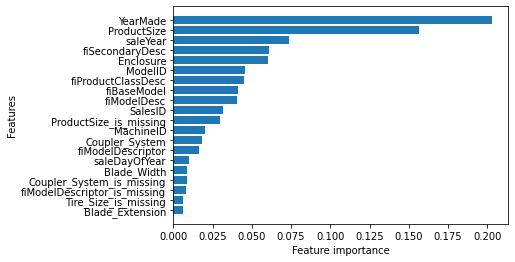

In [54]:
plot_features(X_train.columns, ideal_model.feature_importances_)